## Fungi Image Classification

In [288]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import cv2
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add, MaxPool2D
import keras
#from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, AdamW

print("Tensorflow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

project_path = 'Defungi_S'
# project_path = 'Defungi'
project_seed = 42
#project_image_size = (32,32)
project_image_size = (128,128)
#project_image_size = (500,500)
project_filter_size = 256
project_batch_size = 32
project_epochs = 5;
project_folds = 5;
project_auto = tf.data.AUTOTUNE
# project_batch_size = 128

Tensorflow Version: 2.14.0
Keras Version: 2.14.0


In [445]:
def variance_of_Laplacian(image_path, ker_edge_detect):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img = cv2.filter2D(src = image_gray.astype("uint8"), ddepth = -1, kernel = ker_edge_detect)
    variance = np.var(img)
    return variance

#    variance = np.zeros((1,3))
#    for i in range(3):
#        img = cv2.filter2D(src = image[i].astype("uint8"), ddepth = -1, kernel = ker_edge_detect)
#        variance[0,i] = np.var(img)
#    return variance.mean()


### Preprocessing the Data and Organizing as a csv-file

In [572]:
# Load data from the directory using Pandas
# image_data = 'Defungi'

files = [i for i in glob.glob(project_path + "//*//*")]
np.random.shuffle(files)

# Taking the 2 symbols between the string 'Defungi\' and the file-name
labels = [os.path.dirname(i).split("/")[-1][-2:] for i in files]
fungus_classes = {'H1':0, 'H2':1, 'H3':2, 'H5':3, 'H6':4}
classes = [fungus_classes[labels[i]] for i in range(len(labels))]

# Kernels for edge detecting
ker_edge_detect_1 = np.array([[-1, -1, -1], 
                              [-1,  8, -1], 
                              [-1, -1, -1]])
ker_edge_detect_2 = np.array([[ 0, -1,  0], 
                              [-1,  4, -1], 
                              [ 0, -1,  0]])
ker_Sobel_x = np.array([[ -1,  0,  1], 
                        [ -2,  0,  2], 
                        [ -1,  2,  1]])
ker_Sobel_y = np.array([[ -1, -2, -1], 
                        [  0,  0,  0], 
                        [  1,  2,  1]])
edge_1 = [variance_of_Laplacian(i, ker_edge_detect_1) for i in glob.glob(project_path + "//*//*")]
edge_2 = [variance_of_Laplacian(i, ker_edge_detect_2) for i in glob.glob(project_path + "//*//*")]
Sobel_x = [variance_of_Laplacian(i, ker_Sobel_x) for i in glob.glob(project_path + "//*//*")]
Sobel_y = [variance_of_Laplacian(i, ker_Sobel_y) for i in glob.glob(project_path + "//*//*")]
#Class = [fungus_classes[labels(i)] for i in files]

data = zip(files, labels, classes, edge_1/max(edge_1), edge_2/max(edge_2), Sobel_x/max(Sobel_x), Sobel_y/max(Sobel_y))
dataframe = pd.DataFrame(data, columns = ["Image", "Label", "Class", "Edge_1", "Edge_2", "Sobel_x", "Sobel_y"])
dataframe.to_csv(project_path + '\Defungi.csv')
print(dataframe)

                         Image Label  Class    Edge_1    Edge_2   Sobel_x  \
0     Defungi_S\H6\H6_2c_6.jpg    H6      4  0.095850  0.056747  0.102535   
1     Defungi_S\H6\H6_1c_2.jpg    H6      4  0.019137  0.011429  0.023716   
2     Defungi_S\H6\H6_4a_1.jpg    H6      4  0.061266  0.036339  0.083424   
3     Defungi_S\H5\H5_1a_4.jpg    H5      3  0.061163  0.036455  0.067942   
4     Defungi_S\H5\H5_4a_3.jpg    H5      3  0.033559  0.019875  0.002965   
..                         ...   ...    ...       ...       ...       ...   
395   Defungi_S\H2\H2_4a_1.jpg    H2      1  0.144820  0.088345  0.017034   
396  Defungi_S\H3\H3_1b_11.jpg    H3      2  0.203860  0.124536  0.187308   
397   Defungi_S\H5\H5_4a_2.jpg    H5      3  0.228287  0.138214  0.203658   
398   Defungi_S\H1\H1_1d_3.jpg    H1      0  0.133789  0.080366  0.024018   
399  Defungi_S\H3\H3_1a_29.jpg    H3      2  0.131052  0.079093  0.024284   

      Sobel_y  
0    0.035486  
1    0.014671  
2    0.032913  
3    0.0309

### Exploring the Data

In [573]:
# Load training and testing data from the xray_data dataset using Pandas
Defungi_data = pd.read_csv(project_path + '\Defungi.csv')
Defungi_data.info()
print(Defungi_data.head(4))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  400 non-null    int64  
 1   Image       400 non-null    object 
 2   Label       400 non-null    object 
 3   Class       400 non-null    int64  
 4   Edge_1      400 non-null    float64
 5   Edge_2      400 non-null    float64
 6   Sobel_x     400 non-null    float64
 7   Sobel_y     400 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 25.1+ KB
   Unnamed: 0                     Image Label  Class    Edge_1    Edge_2  \
0           0  Defungi_S\H6\H6_2c_6.jpg    H6      4  0.095850  0.056747   
1           1  Defungi_S\H6\H6_1c_2.jpg    H6      4  0.019137  0.011429   
2           2  Defungi_S\H6\H6_4a_1.jpg    H6      4  0.061266  0.036339   
3           3  Defungi_S\H5\H5_1a_4.jpg    H5      3  0.061163  0.036455   

    Sobel_x   Sobel_y  
0  0.102535  0.035

In [574]:
Defungi_data.describe()

,Unnamed: 0,Class,Edge_1,Edge_2,Sobel_x,Sobel_y
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,199.500000,2.000000,0.173201,0.109980,0.113351,0.063041
std,115.614301,1.415985,0.137263,0.101146,0.157768,0.125216
min,0.000000,0.000000,0.004204,0.002493,0.000000,0.005765
25%,99.750000,1.000000,0.074010,0.043381,0.015141,0.019287
50%,199.500000,2.000000,0.136222,0.080494,0.057138,0.027256
75%,299.250000,3.000000,0.249182,0.153827,0.152257,0.047358
max,399.000000,4.000000,1.000000,1.000000,1.000000,1.000000


### Uploading the Images from the Directory
#### A small version of Dataset can be uploaded for testing models and algorithms

In [165]:
import pathlib

data_dir = pathlib.Path(project_path)

data_train, data_test = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    subset = 'both',
    labels = 'inferred',
#    label_mode = 'int',
    color_mode = 'rgb',
    image_size = project_image_size,
    batch_size = project_batch_size,
    seed = project_seed,
    validation_split = 0.3)

for x, y in data_test.take(4):
    print(x.shape, y)


Found 400 files belonging to 5 classes.
Using 280 files for training.
Using 120 files for validation.
(32, 128, 128, 3) tf.Tensor([0 3 4 1 2 4 2 2 1 2 0 0 0 3 2 4 0 3 2 3 3 2 4 1 0 1 1 0 0 3 0 1], shape=(32,), dtype=int32)
(32, 128, 128, 3) tf.Tensor([0 4 4 2 3 4 2 2 2 3 4 3 4 4 3 3 2 2 0 2 2 3 3 1 0 0 0 1 2 0 3 1], shape=(32,), dtype=int32)
(32, 128, 128, 3) tf.Tensor([4 0 4 3 3 0 3 1 3 2 4 4 1 3 4 3 3 0 0 2 2 4 2 2 0 0 4 2 3 0 3 2], shape=(32,), dtype=int32)
(24, 128, 128, 3) tf.Tensor([3 2 3 4 3 3 1 1 1 4 1 4 1 4 2 1 4 0 2 0 1 3 4 1], shape=(24,), dtype=int32)


In [587]:
Defungi_data = pd.read_csv(project_path + '/Defungi.csv')
Quantile = Defungi_data[['Edge_1','Sobel_x','Sobel_y']].quantile(0.25)

# Drop the blured datapoints (edges are not clear according to three types of algorithms
# (a simple kernel 8 surrounded by negative ones and two Sobel edges) 
Defungi_data_clear = Defungi_data.loc[(Defungi_data['Edge_1'] > Quantile['Edge_1']) | (Defungi_data['Sobel_x'] > Quantile['Sobel_x']) | (Defungi_data['Sobel_y'] > Quantile['Sobel_y'])]
Defungi_data_clear.reset_index(drop = True, inplace = True)
print(Defungi_data_clear.describe())

Image_Array = []
Class_Array = []
for i in Defungi_data_clear.index:
    Image_Path = Defungi_data_clear.loc[i, "Image"]
    Class = Defungi_data_clear.loc[i, "Class"]
    Class_Array.append(Class)
    Image = keras.utils.load_img(Image_Path, target_size = project_image_size)
    Keras_Image = keras.utils.img_to_array(Image)
    Image_Array.append(np.array([Keras_Image]))

print(type(Image_Array))
print(len(Image_Array))
print(len(Class_Array))

       Unnamed: 0       Class      Edge_1      Edge_2     Sobel_x     Sobel_y
count  361.000000  361.000000  361.000000  361.000000  361.000000  361.000000
mean   207.285319    2.008310    0.189150    0.120233    0.125000    0.068345
std    112.860209    1.424951    0.135017    0.101218    0.161831    0.130719
min      0.000000    0.000000    0.006300    0.003742    0.000096    0.005765
25%    114.000000    1.000000    0.090827    0.053047    0.022648    0.021770
50%    208.000000    2.000000    0.153354    0.092777    0.068969    0.029172
75%    307.000000    3.000000    0.267801    0.163019    0.164312    0.050464
max    399.000000    4.000000    1.000000    1.000000    1.000000    1.000000
<class 'list'>
361
361


### Displaying the Images

32


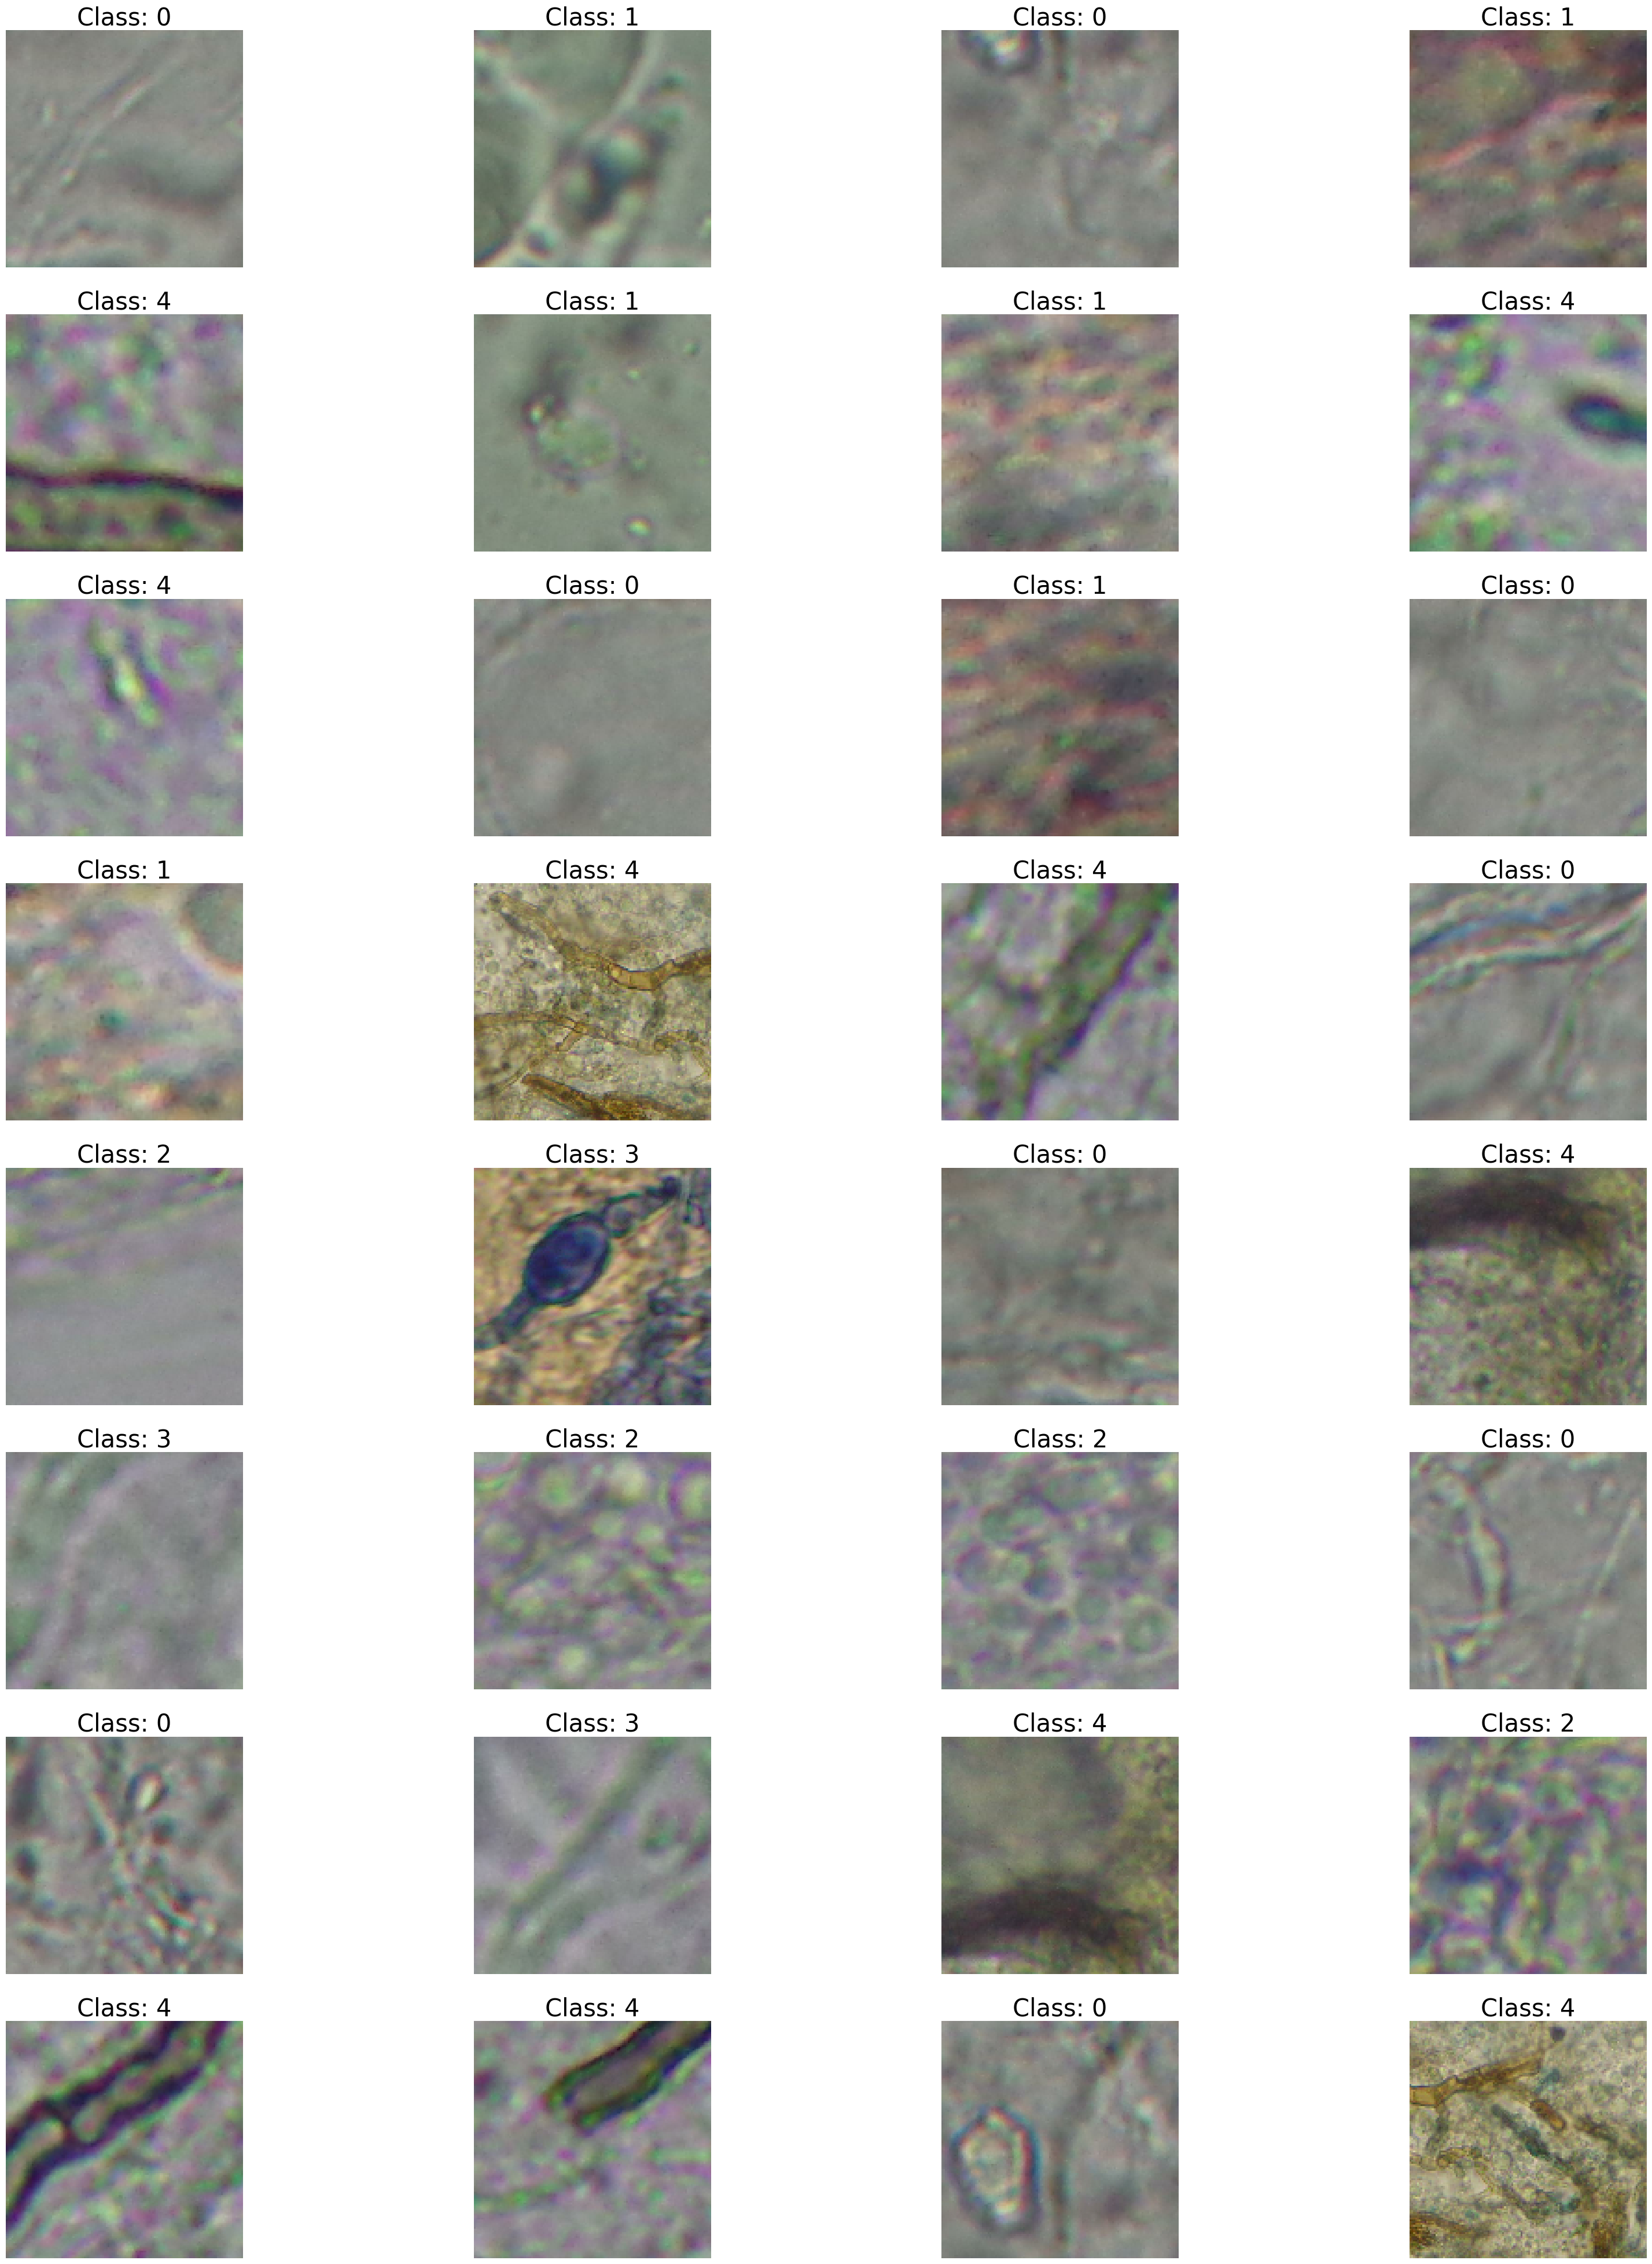

In [166]:
# Display the images
data_iterator = data_train.as_numpy_iterator()
images, labels = data_iterator.next()
print(len(images))
#plt.figure(figsize = (12, 8))
plt.figure(figsize = (40,50))
for i in range(len(images)):
    plt.subplot(8, 4, i + 1)
    plt.imshow(images[i].astype("uint8"))
#    plt.title(f'Class: {np.argmax(labels[i])}')
    plt.title(f'Class: {labels[i]}', fontsize = 30) 
    plt.axis('off')

plt.show()

### Checking the Number of Data in Each Class

Label
H1    80
H5    80
H6    80
H3    80
H2    80
Name: count, dtype: int64


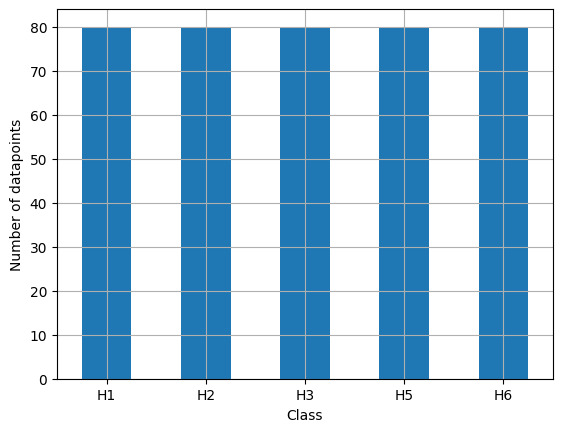

In [167]:
Cat = Defungi_data["Label"].value_counts()
print(Cat)
Defungi_data["Label"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Class")
plt.ylabel("Number of datapoints")
plt.show()

### Data Augmentation

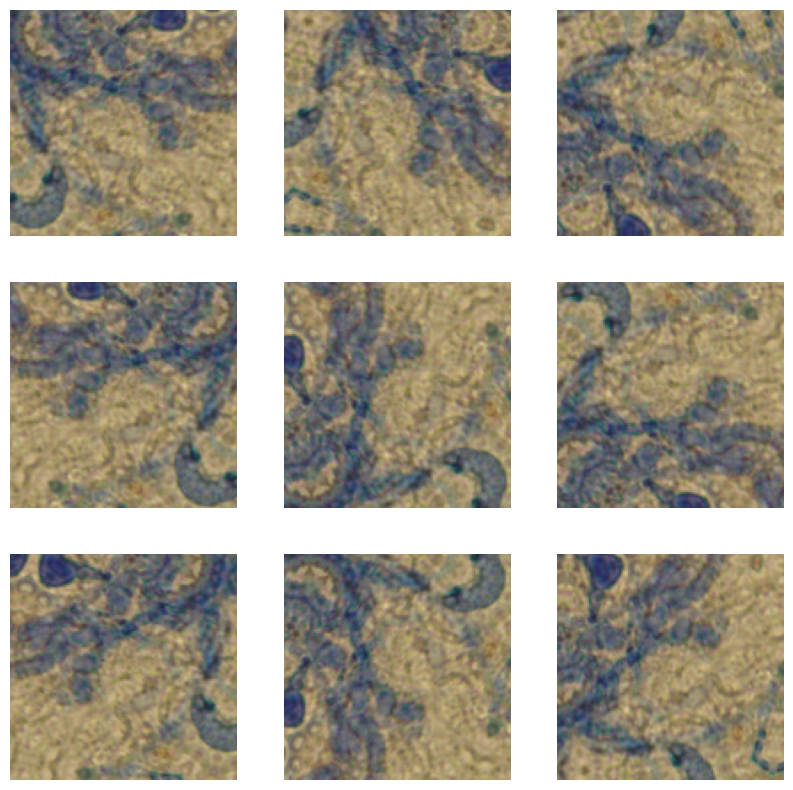

In [168]:
# Data Augmentation of the training images

data_augmentation = keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(factor = (-0.5, 0.5)),
    ])

data_train = data_train.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
data_train = data_train.prefetch(tf.data.AUTOTUNE)
data_rest = data_test.prefetch(tf.data.AUTOTUNE)

#print(data_train.element_spec)
#for x, y in data_train.take(1000):
#    print(x.shape, y)

plt.figure(figsize=(10, 10))
for images, _ in data_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### ResNet Model 

In [283]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500
def model_fungi_book(data_shape, number_of_classes, filter_size):

    inputs = keras.Input(shape = data_shape)
    # Rescaling reads a directory of images on disk
#    keras.regularizers.l1_l2(l1=0.01, l2=0.001)
    # Add AUGMENTATION
    x = tf.keras.layers.Rescaling(1/255.0)(inputs)

    x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 7, strides = 2, padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same")(x)

    prev_filters = 64
    residual = x  # Set aside residual
        
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        if filters == prev_filters:
            strides = 1
        else:
            strides = 2
        x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(residual)
#        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
#        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        if filters != prev_filters:
            residual = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 1, strides = 4)(residual)
            
        x = tf.keras.layers.add([x, residual])  # Add back residual
        residual = tf.keras.layers.Activation("relu")(x)
        prev_filters = filters
            
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_11 (Rescaling)    (None, 128, 128, 3)          0         ['input_12[0][0]']            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 64, 64, 64)           9472      ['rescaling_11[0][0]']        
                                                                                                  
 batch_normalization_363 (B  (None, 64, 64, 64)           256       ['conv2d_11[0][0]']           
 atchNormalization)                                                                        

### MLP-Mixer Model

In [243]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500
def model_fungi_conv_mixer(data_shape, number_of_classes, filter_size):

    inputs = keras.Input(shape = data_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1/255.0)(x)

    # Conv2D is a class that spatial convolution over images
    # filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
    # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
    # strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
    # padding: one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.
    # in https://www.kaggle.com/code/banddaniel/fungus-detect-w-10cv-custom-convmixer-f1-0-85/notebook
    # filter = 256
    x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 2, strides = 2, padding = "same")(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    vector_of_ones = np.ones(3, dtype = int)
    print(vector_of_ones)
    kernel_size = 5
    for size in 256 * vector_of_ones:
        x = tf.keras.layers.DepthwiseConv2D(kernel_size = kernel_size, strides = 2, padding = 'same')(x)
        x = tf.keras.layers.Activation('gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
#        x = tf.keras.layers.Add(inputs)
#        x = tf.keras.layers.Add()([x, inputs])
        x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 1)(x)
        x = tf.keras.layers.Activation('gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    X = tf.keras.layers.GlobalAveragePooling2D()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    outputs = tf.keras.layers.Dense(units, activation = activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = project_filter_size)
model.summary()

[1 1]
Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_107 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 sequential_20 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 rescaling_93 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_322 (Conv2D)         (None, 16, 16, 256)       3328      
                                                                 
 activation_578 (Activation  (None, 16, 16, 256)       0         
 )                                                               
                                                                 
 batch_normalization_578 (B  (None, 16, 16, 256)       1024      
 atchNormalization)                                 

### Fitting Network

In [291]:
# training method "sgd" means that the model will be trained
# using stochastic gradient descent
# learning_rate is 0.001 (defaults learning rate is 0.01)
learning_rate = 0.0001
sgd = SGD(learning_rate = learning_rate)
Adamar = Adam(learning_rate = learning_rate)
#Adamar = AdamW(learning_rate = learning_rate)
epochs = 10

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
#scaler = preprocessing.StandardScaler().fit(data_train)

model.compile(
    optimizer = Adamar,
    loss = "sparse_categorical_crossentropy",
    metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = "top_2_acc", dtype = None)])
#    metrics = ["accuracy"])

#acc_loss = model.fit(
#    data_train,
#    epochs = epochs,
#    callbacks = callbacks,
#    validation_data = data_test)

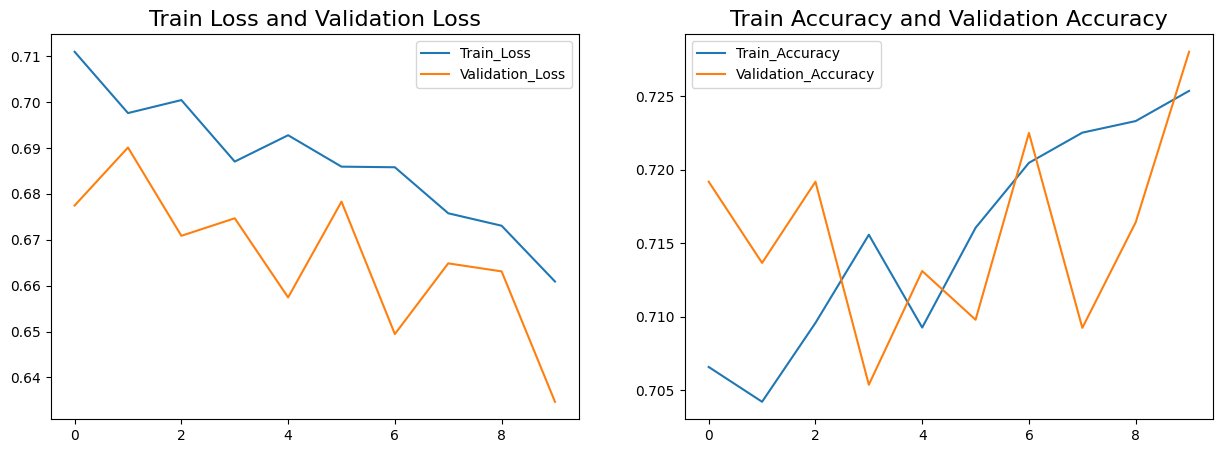

In [190]:
acc_loss_show = pd.DataFrame(acc_loss.history)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(acc_loss_show['loss'],label='Train_Loss')
plt.plot(acc_loss_show['val_loss'],label='Validation_Loss')
plt.title('Train Loss and Validation Loss',fontsize = 16)
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_loss_show['accuracy'],label='Train_Accuracy')
plt.plot(acc_loss_show['val_accuracy'],label='Validation_Accuracy')
plt.title('Train Accuracy and Validation Accuracy',fontsize = 16)
plt.legend()

In [339]:
def variance_of_Laplacian(image):
    ker_edge_detect = np.array([[ 0, -1,  0], 
                                [-1,  4, -1], 
                                [ 0, -1,  0]])
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img = cv2.filter2D(src = image_gray, ddepth = -1, kernel = ker_edge_detect)
    variance = np.var(img)
    return variance

Path = "C:\\Users\\olgat\\OneDrive\\PYTHON\\ML\\Defungi_S\\H1\\H1_1a_22.jpg"
image = cv2.imread(Path)
print(type(image))
print(image.shape)
print(type(images.numpy()))
print(images.numpy().shape)
var = variance_of_Laplacian(image)
print(var)
var = variance_of_Laplacian(np.array(images[31,:,:,:]))
print(var)

<class 'numpy.ndarray'>
(500, 500, 3)
<class 'numpy.ndarray'>
(32, 128, 128, 3)
1.4040138769760004
18.53733


### K-fold Validation

In [341]:
fold_hists = []
test_evals = []
test_preds = []

X_train = []
y_train = []

kf = KFold(n_splits = project_folds, shuffle = True, random_state = project_seed)

# for i, (train_index, val_index) in enumerate(kf.split(data_train['img'], train_df['label'])):
for images, labels in data_train:
    var = variance_of_Laplacian(images)
    print(var)
    cv2.imshow('Original', images) 
    
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

for i, (train_indices, val_indices) in enumerate(kf.split(X_train, y_train)):
# for train_index, val_index in enumerate(kf):

    print('-'*80)
    print(str(i+1) + '.fold training')
    
    X_train_fold = [X_train[k] for k in train_indices]
    y_train_fold = [y_train[k] for k in train_indices]
    
    X_val_fold = [X_train[k] for k in val_indices]
    y_val_fold = [y_train[k] for k in val_indices]
    
    # Creating the pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
#                     .map(image_preprocessing, num_parallel_calls = project_auto)
#                     .map(augmentation, num_parallel_calls = project_auto)
                     .batch(project_batch_size)
                     .shuffle(project_batch_size * project_folds)
                     .prefetch(project_auto))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
#                          .map(image_preprocessing, num_parallel_calls = project_auto)
                          .batch(project_batch_size)
                          .prefetch(project_auto))
    
    # Training
    hist = model.fit(train_dataset,
                     epochs = project_epochs,
                     batch_size = project_batch_size,
                     callbacks = callbacks,
                     validation_data = validation_dataset)

    #acc_loss = model.fit(
#    data_train,
#    epochs = epochs,
#    callbacks = callbacks,
#    validation_data = data_test)
    
    fold_hists.append(hist)
    
    # Test evaluation
#    test_eval = model.evaluate(test_dataset)
    test_eval = model.evaluate(data_test)
    test_evals.append(test_eval)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))
    print('Test Sparse Top 2 Accuracy: {0:.2f} %'.format(test_eval[2]*100))
    
    # Test set prediction
    test_take1 =  data_test.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    test_preds.append(pred)

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [155]:
from sklearn.metrics import classification_report, confusion_matrix

# Testing the model using test data
# Function predict() predicts the labels of the data values
# on the basis of the trained model
# predictions is a vector of probabilities for each digit

predictions = model.predict(data_test)
# predicted digit is one with the greatest probability

y_pred = np.argmax(predictions,axis=1)

85/85 [==============================] - 17s 194ms/step


In [174]:
y_pred = np.argmax(predictions,axis=1)

y_test = []
for images, labels in data_test:
    y_test.extend(labels.numpy())
    
# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, y_test))

# Classification report includes precision,
# recall, f1-score, and the number of actual occurrences
print('Classification Report')

# y_test
print(classification_report(y_pred, y_test))

Confusion Matrix
[[1170  305   50   12    7]
 [ 126  271   24   28   14]
 [  29   40  171   19    5]
 [   1   31   13  189    8]
 [   0    2    1    1  196]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1544
           1       0.42      0.59      0.49       463
           2       0.66      0.65      0.65       264
           3       0.76      0.78      0.77       242
           4       0.85      0.98      0.91       200

    accuracy                           0.74      2713
   macro avg       0.71      0.75      0.73      2713
weighted avg       0.77      0.74      0.75      2713

